In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
import seaborn as sns
import ristretto.activations as ra
import ristretto.models as rm
import ristretto.utils as ru
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
# from torch.utils.tensorboard import SummaryWriter

/home/daniicereezzo/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# set pytorch precision
torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_dtype(torch.float32)
# activate 
ra.ReLUFunction.print_when_zero = True

In [4]:
def get_epoch_val(metrics, epochs=10, batch_size=128):
    """Gets the accuracy of an epoch for a given model."""
    epoch_val = np.arange(epochs)
    model_epoch =[]

    for m in range(len(metrics)):
        for i in range(epochs):
            len_epoch = int(len(metrics[m]["validation"]['correct'])/epochs)
            index = i*len_epoch
            epoch_val[i] = (metrics[m]["validation"]['correct'][index:index+len_epoch].sum())
            aux = epoch_val.copy()/10000
        model_epoch.append(aux)
    return model_epoch


def get_epoch_train(metrics, epochs=10, batch_size=128):
    """Gets the accuracy of an epoch for a given model."""
    epoch_val = np.arange(epochs)
    model_epoch =[]

    for m in range(len(metrics)):
        for i in range(epochs):
            len_epoch = int(len(metrics[m]["train"]['loss'])/epochs)
            index = i*len_epoch
            epoch_val[i] = (metrics[m]["train"]['loss'][index:index+len_epoch].sum())
            aux = epoch_val.copy()/600000
        model_epoch.append(aux)
    return model_epoch

In [5]:
activations = [0, -0.5, 0.5, 0.8, 1]

new_models = []
for activition in activations:
    new_models.append(rm.ResNet(activation=partial(ra.ReLU, activition), seed=42069))
      
model_32 = [rm.ResNet(activation=partial(ra.ReLU, 0), seed=42069)]

In [6]:
#This is just to know the index of the models for the plots. 
aux = 0
rel = 0 

for activation in activations:
    print(f"index {aux +1} --> model {aux+2}")
    print(f"Activation: {activation} alpha: {rel}")
    print(f"Model: {new_models[aux]}")
    aux += 1

index 1 --> model 2
Activation: 0 alpha: 0
Model: ResNet(
  (sequence): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ResidualBlock(
      (C1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (N1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R1): ReLU()
      (C2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (N2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R2): ReLU()
      (C3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (N3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): ResidualBlock(
      (C1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (N1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affi

In [7]:
models_32 = model_32 + new_models

# activate 
ra.ReLUFunction.print_when_zero = True

epochs = 20
metrics_32 = ru.train_multiple_models(
    models_32,
    ru.default.DATA_LOADERS['MNIST'],
    epochs=epochs,
    metrics_fn=lambda m, p, y: {"weight_sum": ru.get_weight_sum(m)}
)

===== Model 1 (ResNet) =====
---------- Epoch  1 ----------
Found 1 item with input == 0


KeyboardInterrupt: 

Took 20min to run 

In [ ]:
import pickle

with open("convolutional_output1_32.bin", "wb") as output:
    pickle.dump(metrics_32, output)
    output.close()


In [ ]:

print("numbers models: ",len(metrics_32),"Which contain: ")
print(metrics_32[0].keys())
print('train contains: ')
print(metrics_32[0]['train'].keys()) 
print('validation contains: ')
print(metrics_32[0]['validation'].keys()) 


numbers models:  6 Which contain: 
dict_keys(['train', 'validation'])
train contains: 
Index(['loss', 'accuracy', 'weight_sum'], dtype='object')
validation contains: 
Index(['loss', 'correct', 'accuracy', 'weight_sum'], dtype='object')


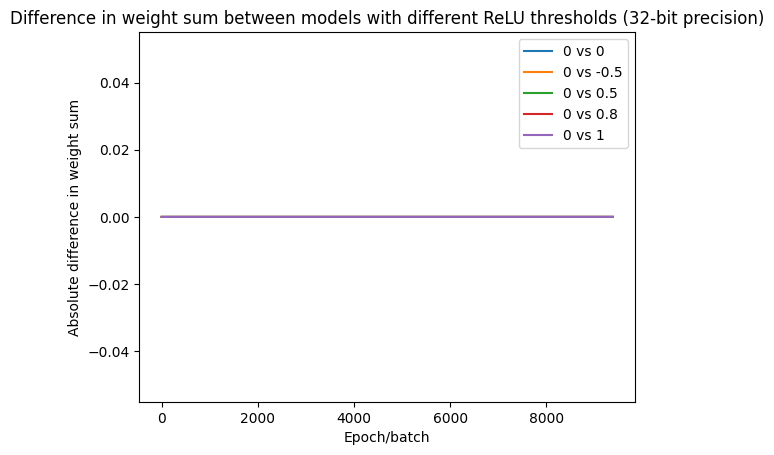

In [ ]:
diff = pd.DataFrame({
    "0 vs 0": np.abs(metrics_32[0]["train"]['weight_sum'] - metrics_32[1]["train"]['weight_sum']),
    "0 vs -0.5": np.abs(metrics_32[0]["train"]['weight_sum'] - metrics_32[2]["train"]['weight_sum']),
    "0 vs 0.5": np.abs(metrics_32[0]["train"]['weight_sum'] - metrics_32[3]["train"]['weight_sum']),
    "0 vs 0.8": np.abs(metrics_32[0]["train"]['weight_sum'] - metrics_32[4]["train"]['weight_sum']),
    "0 vs 1": np.abs(metrics_32[0]["train"]['weight_sum'] - metrics_32[5]["train"]['weight_sum'])
})
sns.lineplot(data=diff, dashes=False)
plt.xlabel("Epoch/batch")
plt.ylabel("Absolute difference in weight sum")
plt.title("Difference in weight sum between models with different ReLU thresholds (32-bit precision)");

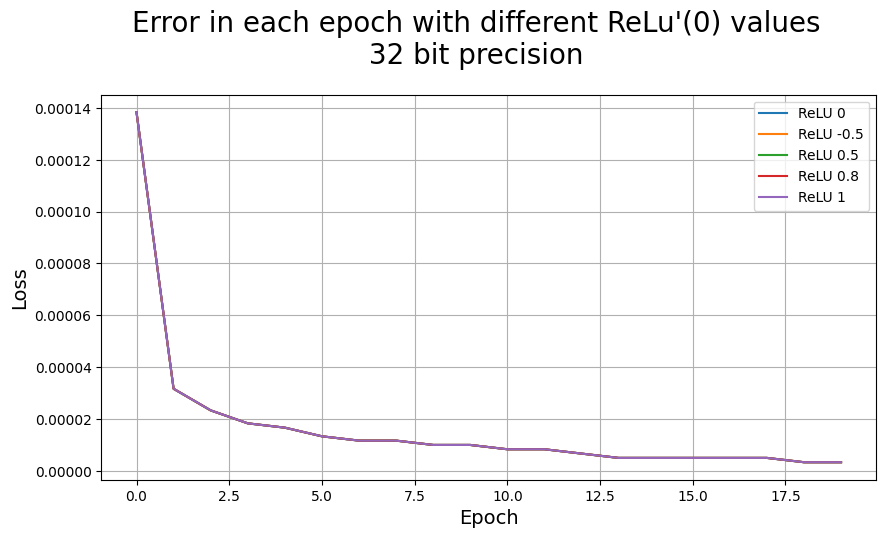

In [ ]:
loss_32 = get_epoch_train(metrics_32, epochs=epochs, batch_size=128)

fig = plt.figure(figsize=(10,5))
plt.plot(loss_32[1], label='ReLU 0')
plt.plot(loss_32[2], label='ReLU -0.5')
plt.plot(loss_32[3], label='ReLU 0.5')
plt.plot(loss_32[4], label='ReLU 0.8')
plt.plot(loss_32[5], label='ReLU 1')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.suptitle("Error in each epoch with different ReLu'(0) values\n 32 bit precision ", fontsize=20, y=1.05)
plt.legend()
plt.grid()
plt.show()

In [ ]:
model32_epoch = get_epoch_val(metrics_32, epochs=epochs, batch_size=128)

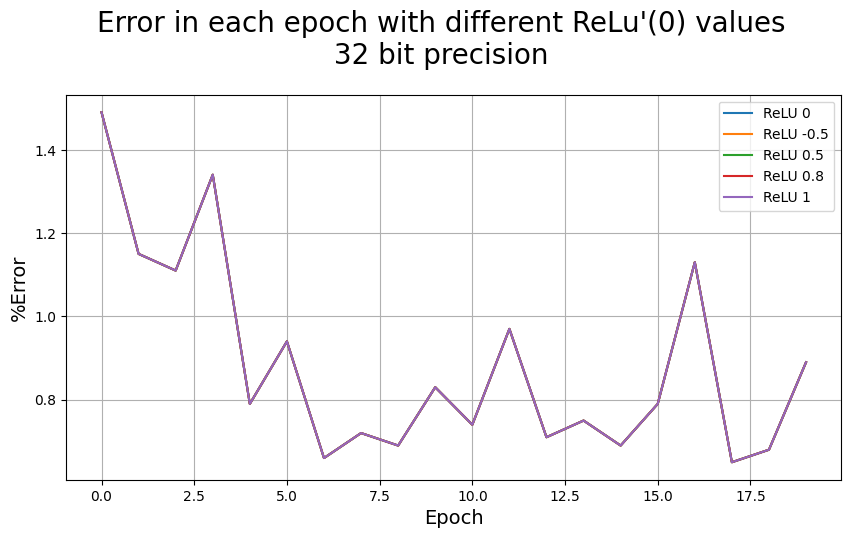

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot((1-model32_epoch[1])*100, label='ReLU 0')
plt.plot((1-model32_epoch[2])*100, label='ReLU -0.5')
plt.plot((1-model32_epoch[3])*100, label='ReLU 0.5')
plt.plot((1-model32_epoch[4])*100, label='ReLU 0.8')
plt.plot((1-model32_epoch[5])*100, label='ReLU 1')
plt.ylabel('%Error', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.suptitle("Error in each epoch with different ReLu'(0) values\n 32 bit precision ", fontsize=20, y=1.05)
plt.legend()
plt.grid()
plt.show()

### When trained with 16-bit precision the difference between the models is even greater

In [ ]:
# set pytorch precision
torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_dtype(torch.bfloat16)

In [ ]:
activations = [0, -0.5, 0.5, 0.8, 1]

new_models_16 = []
for activition in activations:
    new_models_16.append(rm.ResNet(activation=partial(ra.ReLU, activition), seed=42069))
      
model_16 = [rm.ResNet(activation=partial(ra.ReLU, 0), seed=42069)]

In [ ]:
#This is just to know the index of the models for the plots. 
aux = 0
rel = 0 

for activation in activations:
    print(f"index {aux +1} --> model {aux+2}")
    print(f"Activation: {activation} alpha: {rel}")
    print(f"Model: {new_models_16[aux]}")
    aux += 1

index 1 --> model 2
Activation: 0 alpha: 0
Model: ResNet(
  (sequence): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ResidualBlock(
      (C1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (N1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R1): ReLU()
      (C2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (N2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R2): ReLU()
      (C3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (N3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): ResidualBlock(
      (C1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (N1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affi

In [ ]:
epochs = 20
models_16 = model_16 + new_models_16

metrics_16 = ru.train_multiple_models(
    models_16,
    ru.default.DATA_LOADERS['MNIST'],
    epochs=epochs,
    metrics_fn=lambda m, p, y: {"weight_sum": ru.get_weight_sum(m)}
)

===== Model 1 (ResNet) =====
---------- Epoch  1 ----------
Found 366 items with input == 0
Found 387 items with input == 0
Found 382 items with input == 0
Found 468 items with input == 0
Found 356 items with input == 0
Found 505 items with input == 0
Found 697 items with input == 0
Found 1154 items with input == 0
Found 726 items with input == 0
Found 992 items with input == 0
Found 719 items with input == 0
Found 1393 items with input == 0
Found 1104 items with input == 0
Found 1277 items with input == 0
Found 1349 items with input == 0
Found 835 items with input == 0
Found 923 items with input == 0
Found 996 items with input == 0
Found 1392 items with input == 0
Found 350 items with input == 0
Found 2 items with input == 0
Found 350 items with input == 0
Found 4 items with input == 0
Found 347 items with input == 0
Found 666 items with input == 0
Found 665 items with input == 0
Found 2 items with input == 0
Found 762 items with input == 0
Found 996 items with input == 0
Found 1020 i

KeyboardInterrupt: 

Ran in 12 30.4 min

In [ ]:
diff = pd.DataFrame({
    "0 vs 0": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[1]["train"]['weight_sum']),
    "0 vs -0.5": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[2]["train"]['weight_sum']),
    "0 vs 0.5": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[3]["train"]['weight_sum']),
    "0 vs 0.8": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[4]["train"]['weight_sum']),
    "0 vs 1": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[5]["train"]['weight_sum'])
})

sns.lineplot(data=diff, dashes=False)
plt.xlabel("Epoch/batch")
plt.ylabel("Absolute difference in weight sum")
plt.title("Difference in weight sum between models with different ReLU thresholds (16-bit precision)");

In [ ]:
loss_16 = get_epoch_train(metrics_16, epochs=20, batch_size=128)

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(loss_16[1], label='ReLU 0')
plt.plot(loss_16[2], label='ReLU -0.5')
plt.plot(loss_16[3], label='ReLU 0.5')
plt.plot(loss_16[4], label='ReLU 0.8')
plt.plot(loss_16[5], label='ReLU 1')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.suptitle("Error in each epoch with different ReLu'(0) values\n 16 bit precision ", fontsize=20, y=1.05)
plt.legend()
plt.grid()
plt.show()

In [ ]:
model16_epoch = get_epoch_val(metrics_16, epochs=20, batch_size=128)

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot((1-model16_epoch[1])*100, label='ReLU 0')
plt.plot((1-model16_epoch[2])*100, label='ReLU -0.5')
plt.plot((1-model16_epoch[3])*100, label='ReLU 0.5')
plt.plot((1-model16_epoch[4])*100, label='ReLU 0.8')
plt.plot((1-model16_epoch[5])*100, label='ReLU 1')
plt.ylabel('%Error', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.suptitle("Error in each epoch with different ReLu'(0) values\n 16 bit precision ", fontsize=20, y=1.05)
plt.legend()
plt.grid()
plt.show()

In [ ]:
with open("convolutional_output1_16.bin", "wb") as output: #Im storing the esperiment results for further testing 
    pickle.dump(metrics_16, output)
    output.close()

Additional plots 

In [ ]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

with open("convolutional_output1_16.bin", "rb") as data:
    metrics_16 = pickle.load(data)
    
with open("convolutional_output1_32.bin", "rb") as data:
    metrics_32 = pickle.load(data)

df_16 = pd.DataFrame(metrics_16)
df_32 = pd.DataFrame(metrics_32)
batch = 128
alphas = [0,0,-0.5,0.5,0.8,1]

In [ ]:
new_df_16 = pd.DataFrame(columns=['relu', 'test_accuracy'])

for i in range(len(alphas)):
    for j in range(len(metrics_16[i]["validation"]["loss"].values)):
        new_df_16 = new_df_16.append({'relu': alphas[i], 'test_accuracy': metrics_16[i]['validation']['correct'].values[j] /batch}, ignore_index=True);

new_df_32 = pd.DataFrame(columns=['relu', 'test_accuracy'])
for i in range(len(alphas)):
    for j in range(len(metrics_32[i]["validation"]["loss"].values)):
        new_df_32 = new_df_32.append({'relu': alphas[i], 'test_accuracy': metrics_32[i]['validation']['correct'].values[j] /batch}, ignore_index=True);

In [ ]:
g = sns.catplot(data=new_df_16, x="relu", y="test_accuracy", kind="box", hue="relu", height=4, aspect=2 )
plt.get_figlabels()
plt.legend(title = "ReLU'(0)", loc='best', bbox_to_anchor=(0.75, 0.3, 0.5, 0.5));
plt.suptitle("Test accuracy for different\n ReLU thresholds (16-bit precision)", fontsize=18, y=1.2, x=0.6);
plt.xlabel("ReLU'(0)", fontsize=18); 
plt.ylabel('Test accuracy', fontsize=18);
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks([-.32,0.84,2,3.16,4.32], labels, fontsize=18);
plt.grid(True)


In [ ]:
h= sns.catplot(data=new_df_32, x="relu", y="test_accuracy", kind="box", hue="relu", height=4, aspect=2)
plt.legend(title = "ReLU'(0)", loc='best', bbox_to_anchor=(0.75, 0.3, 0.5, 0.5));
plt.suptitle("Test accuracy for different\n ReLU thresholds (32-bit precision)", fontsize=18, y=1.2, x=0.6);
plt.xlabel("ReLU'(0)", fontsize=18);
plt.xticks([-.32,0.84,2,3.16,4.32], labels, fontsize=18);
plt.ylabel('Test accuracy', fontsize=18);
plt.grid(True)

In [ ]:
fig = plt.figure(figsize=(8,4))
sns.boxplot(data=new_df_16, x="relu", y="test_accuracy" , hue="relu", color="blue") 
sns.boxplot(data=new_df_32, x="relu", y="test_accuracy", hue="relu" , color="red")
plt.legend(title = "ReLU'(0)", loc='best', bbox_to_anchor=(0.75, 0.3, 0.5, 0.5));
plt.suptitle("Test accuracy for different\n ReLU thresholds (32 and 16-bit precision comparisson)", fontsize=18, y=1.1, x=0.6);
plt.text(4.7, 1, '16-bit precision', fontsize=18, color='blue')
plt.text(4.7, 0.9, '32-bit precision', fontsize=18, color='red')
plt.xlabel("ReLU'(0)", fontsize=18);
plt.xticks([-.32,0.84,2,3.16,4.32], labels, fontsize=18);
plt.ylabel('Test accuracy', fontsize=18);
plt.grid(True)